<a href="https://colab.research.google.com/github/tidaltamu/workshops/blob/main/beginner/workshop6/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Beginner Lecture 6

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Kernel Regression

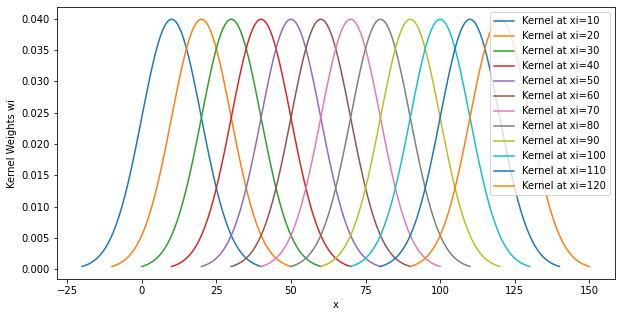

In [ ]:
from scipy.stats import norm
import math

class GKR: # pass paratemer x y b
  def __init__(self, x, y, b):
    self.x = x
    self.y = y
    self.b = b
  
  # implement the Gaussian Kernel
  def gaussian_kernel(self, z):
    return (1/math.sqrt(2*math.pi))*math.exp(-0.5*z**2)
    # write out the mathmatical equation as ccode

  # calculate the weights and return prediction
  def predict(self, X): # X-feature vector whose target value has to be predicted
    kernels = [self.gaussian_kernel((xi-X)/self.b) for xi in self.x]
    weights = [len(self.x) * (kernel/np.sum(kernels)) for kernel in kernels]
    return np.dot(weights, self.y)/len(self.x)
  
  def visualize_kernels(self, precision):
    plt.figure(figsize = (10,5))
    for xi in self.x:
      x_normal = np.linspace(xi - 3*self.b, xi + 3*self.b, precision)
      y_normal = norm.pdf(x_normal, xi, self.b)
      plt.plot(x_normal, y_normal, label='Kernel at xi=' + str(xi))
        
    plt.ylabel('Kernel Weights wi')
    plt.xlabel('x')
    plt.legend()
      
  def visualize_predictions(self, precision, X):
      plt.figure(figsize = (10,5))
      max_y = 0
      for xi in self.x:
          x_normal = np.linspace(xi - 3*self.b, xi + 3*self.b, precision)
          y_normal = norm.pdf(x_normal, xi, self.b)
          max_y = max(max(y_normal), max_y)
          plt.plot(x_normal, y_normal, label='Kernel at xi=' + str(xi))
          
      plt.plot([X,X], [0, max_y], 'k-', lw=1,dashes=[2, 2])
      plt.ylabel('Kernel Weights wi')
      plt.xlabel('x')
      plt.legend()
gkr = GKR([10,20,30,40,50,60,70,80,90,100,110,120], [2337,2750,2301,2500,1700,2100,1100,1750,1000,1642,2000,1932], 10)
gkr.visualize_kernels(100) # 10, to show that the output graph looks like with less precision

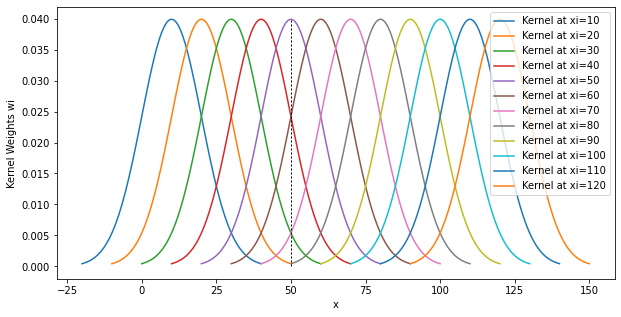

In [ ]:
gkr.visualize_predictions(100,50)

In [ ]:
gkr.predict(100) #from training data, corresponds to 1642

1592.2006006336353

In [ ]:
gkr.predict(50)
# 50 is already present in the training data, right here just want to see how accurate our model is
# from the input we shall notice that 50 is corresponds to 1700, while the output is about 1995.3
# again, more training data, the more accurate the model is

1995.2858171576065

## Ensemble Learning

### Random Forest

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/tidaltamu/workshops/main/beginner/workshop6/data/temps.csv")    # load data
"""
temp_2: max temp 2 days prior
temp_1: max temp 1 day prior
average: historical average max temp
friend: your friend's prediction
actual: the true 
"""
df.head()

,year,month,day,week,temp_2,temp_1,average,actual,friend
0,2016,1,1,Fri,45,45,45.6,45,29
1,2016,1,2,Sat,44,45,45.7,44,61
2,2016,1,3,Sun,45,44,45.8,41,56
3,2016,1,4,Mon,44,41,45.9,40,53
4,2016,1,5,Tues,41,40,46.0,44,41


In [ ]:
df.shape

(348, 9)

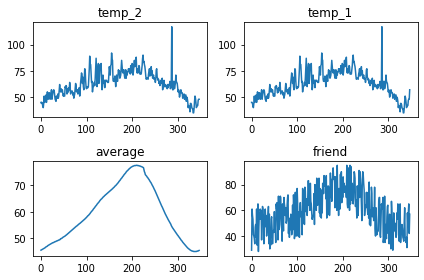

In [ ]:
fig, ax = plt.subplots(2, 2)
cols = [["temp_2", "temp_1"], ["average", "friend"]]
for i in range(2):
    for j in range(2):
        ax[i][j].plot(df.index, df[cols[i][j]])
        ax[i][j].set_title(cols[i][j])
fig.tight_layout()  # reformats subplots to avoid overlapping elements
# max value of temp_1 and temp_2 is probably an outlier

In [ ]:
df = df[df.temp_1 != df.temp_1.max()]   # remove max of temp_1
df = df[df.temp_2 != df.temp_2.max()]   # remove max of temp_2
df = df.reindex()
df.shape    # two rows should be removed

(346, 9)

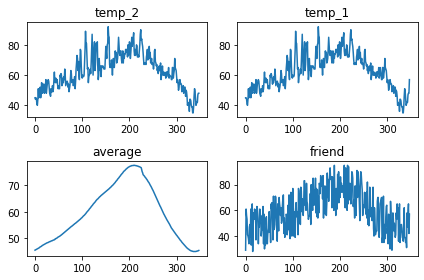

In [ ]:
fig, ax = plt.subplots(2, 2)
cols = [["temp_2", "temp_1"], ["average", "friend"]]
for i in range(2):
    for j in range(2):
        ax[i][j].plot(df.index, df[cols[i][j]])
        ax[i][j].set_title(cols[i][j])
fig.tight_layout()

In [ ]:
# take care of categorical variables
df = pd.concat([df, pd.get_dummies(df.week)], axis=1)   # merge encoded variable on right
df.head()

,year,month,day,week,temp_2,temp_1,average,actual,friend,Fri,Mon,Sat,Sun,Thurs,Tues,Wed
0,2016,1,1,Fri,45,45,45.6,45,29,1,0,0,0,0,0,0
1,2016,1,2,Sat,44,45,45.7,44,61,0,0,1,0,0,0,0
2,2016,1,3,Sun,45,44,45.8,41,56,0,0,0,1,0,0,0
3,2016,1,4,Mon,44,41,45.9,40,53,0,1,0,0,0,0,0
4,2016,1,5,Tues,41,40,46.0,44,41,0,0,0,0,0,1,0


In [ ]:
df = df.drop("week", axis=1)    # week column now redundant
df.head()

,year,month,day,temp_2,temp_1,average,actual,friend,Fri,Mon,Sat,Sun,Thurs,Tues,Wed
0,2016,1,1,45,45,45.6,45,29,1,0,0,0,0,0,0
1,2016,1,2,44,45,45.7,44,61,0,0,1,0,0,0,0
2,2016,1,3,45,44,45.8,41,56,0,0,0,1,0,0,0
3,2016,1,4,44,41,45.9,40,53,0,1,0,0,0,0,0
4,2016,1,5,41,40,46.0,44,41,0,0,0,0,0,1,0


In [ ]:
# separate into independent and dependent variables
y = df["actual"]
X = df.drop("actual", axis=1)

In [ ]:
# split into training and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
# creating, training, and fitting the model
from sklearn.ensemble import RandomForestRegressor  # regressor because this is a regression problem

regressor = RandomForestRegressor(n_estimators=100, random_state=0)    # 100 decision trees
regressor.fit(X_train, y_train);

In [ ]:
y_pred_rf = regressor.predict(X_test)
y_pred_rf

array([43.44, 56.35, 49.03, 79.34, 48.82, 79.55, 67.77, 58.74, 75.66,
       54.47, 59.1 , 69.12, 59.42, 61.9 , 74.63, 68.7 , 75.44, 60.99,
       74.95, 45.17, 55.88, 52.45, 80.43, 76.93, 62.78, 65.81, 46.55,
       48.28, 56.39, 53.04, 51.84, 68.52, 75.77, 76.83, 50.54, 38.09,
       55.85, 69.6 , 70.17, 80.73, 61.12, 60.99, 74.28, 55.52, 59.79,
       69.27, 56.31, 44.64, 60.81, 64.74, 74.33, 72.92, 73.69, 61.25,
       65.19, 60.48, 65.7 , 42.95, 59.18, 77.23, 74.19, 77.23, 74.86,
       52.57, 60.84, 65.5 , 68.15, 55.86, 51.02, 64.39])

In [ ]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred_rf)
print("MSE:", mse)

MSE: 18.820378571428574


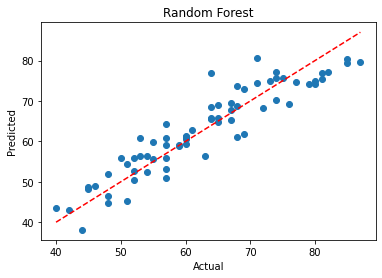

In [ ]:
x = np.linspace(y_test.min(), y_test.max())
plt.scatter(y_test, y_pred_rf)
plt.plot(x, x, "r--")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Random Forest");

### Gradient Boosting

In [ ]:
# creating, training, and fitting the model
from sklearn.ensemble import GradientBoostingRegressor  # regressor because this is a regression problem

# least squares is our loss function
regressor = GradientBoostingRegressor(loss="ls", learning_rate=0.1, 
                                      n_estimators=100, random_state=0)
regressor.fit(X_train, y_train);

In [ ]:
y_pred_gb = regressor.predict(X_test)
y_pred_gb

array([44.33684806, 55.72370686, 48.67225639, 78.74771682, 48.99851046,
       79.26267815, 66.48010186, 57.01823411, 75.70414056, 54.36468844,
       59.43109736, 70.06613591, 58.64030849, 60.18909366, 79.29428636,
       68.75477087, 76.63539496, 61.21771161, 75.84051681, 45.67620905,
       55.69583479, 51.70270353, 79.06076462, 76.79107696, 62.91551358,
       66.30279165, 45.52048192, 47.06149707, 56.34155555, 53.6044643 ,
       52.14195483, 69.34134357, 76.52221516, 75.78733271, 50.35058118,
       37.64122821, 56.90321819, 69.5336237 , 70.34599177, 79.47949545,
       62.13837919, 61.3639248 , 71.57253806, 55.50993985, 59.49371215,
       70.68991078, 58.61777657, 47.46428291, 61.32849492, 65.03810272,
       73.22582619, 75.1303081 , 73.6719852 , 58.0747033 , 65.90364516,
       62.00713656, 65.47357801, 44.69547332, 59.40828808, 77.58485666,
       73.55433934, 76.42983427, 74.8217524 , 51.88293209, 59.5162921 ,
       66.84586765, 67.8993781 , 57.44125895, 50.22902273, 66.71

In [ ]:
mse = mean_squared_error(y_test, y_pred_gb)
print("MSE:", mse)  # slightly worse than random forest

MSE: 20.4221323484393


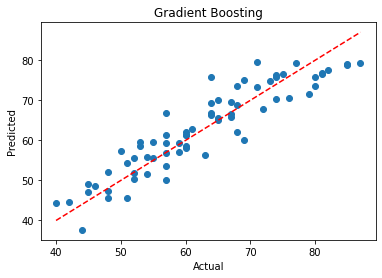

In [ ]:
plt.scatter(y_test, y_pred_gb)
plt.plot(x, x, "r--")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Gradient Boosting");

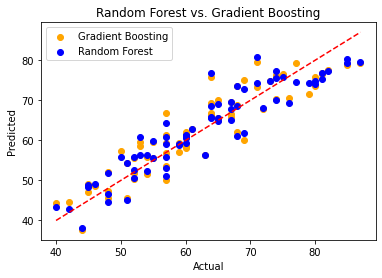

In [ ]:
plt.scatter(y_test, y_pred_gb, c="orange", label="Gradient Boosting")
plt.scatter(y_test, y_pred_rf, c="blue", label="Random Forest")
plt.plot(x, x, "r--")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()
plt.title("Random Forest vs. Gradient Boosting");